# Oil paint filtering

In [95]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

PICTURE_PATH = '../resources/'

In [96]:
img = cv.imread(PICTURE_PATH + "flowers.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

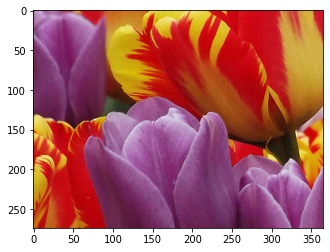

In [97]:
plt.imshow(img)

## Dominant Color Extraction
### Median-Cut

In [98]:
def __median_cut_quantize(img, img_arr):
    # when it reaches the end, color quantize
    r_average = np.mean(img_arr[:,0])
    g_average = np.mean(img_arr[:,1])
    b_average = np.mean(img_arr[:,2])
    for data in img_arr:
        img[data[3]][data[4]] = [r_average, g_average, b_average]
    
def __split_into_buckets(img, img_arr, depth):
    if depth == 0:
        __median_cut_quantize(img, img_arr)
        return
    
    r_range = np.max(img_arr[:,0]) - np.min(img_arr[:,0])
    g_range = np.max(img_arr[:,1]) - np.min(img_arr[:,1])
    b_range = np.max(img_arr[:,2]) - np.min(img_arr[:,2])
    
    space_with_highest_range = 0
    if g_range >= r_range:
        space_with_highest_range = 1
        if b_range >= g_range:
            space_with_highest_range = 2
    elif b_range >= r_range:
        space_with_highest_range = 2

    # sort the image pixels by color space with highest range
    # and find the median and divide the array.
    img_arr = img_arr[img_arr[:,space_with_highest_range].argsort()]
    median_index = int((len(img_arr)+1)/2)
    
    # split the array into two buckets along the median
    __split_into_buckets(img, img_arr[0:median_index], depth-1)
    __split_into_buckets(img, img_arr[median_index:], depth-1)

# the 2rd parameter represents how many colors are needed in the power of 2.
# If the parameter passed is 4 its means 2^4 = 16 colors
def median_cut(img, nb_colors):
    flattened_img_array = []
    for rindex, rows in enumerate(img):
        for cindex, color in enumerate(rows):
            flattened_img_array.append([color[0],color[1],color[2],rindex, cindex])
    flattened_img_array = np.array(flattened_img_array)
    if (len(flattened_img_array) == 0):
        return
    return __split_into_buckets(img, flattened_img_array, nb_colors)

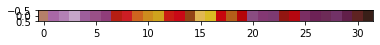

In [99]:
copy_img = np.array(img)
median_cut(copy_img, 5)
palette = []
for h in range(copy_img.shape[0]):
    for w in range(copy_img.shape[1]):
        add = True
        for color in palette:
            if (color[0] == copy_img[h, w, 0] and color[1] == copy_img[h, w, 1] and color[2] == copy_img[h, w, 2]):
                add = False
                break
        if (add):
            palette.append(copy_img[h, w])
palette = np.array([palette])
plt.imshow(palette)

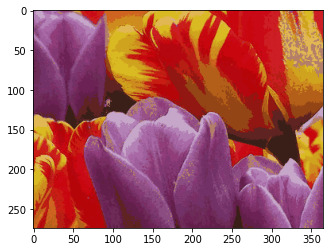

In [100]:
plt.imshow(copy_img)

## Octree

In [101]:
class Octree:
    def __init__(self, depth, is_leaf, color=None):
        self.depth = depth
        self.is_leaf = is_leaf
        self.color_index = None
        self.children = [None] * 8
        self.color_count = 0
        self.color = [0, 0, 0]
        if (is_leaf):
            self.color_count = 1
            self.color = color

def get_bit(value, n):
    return (value >> n & 1)

def get_branch(color, depth):
    n = 8 - depth
    return 4 * get_bit(color[0], n) + 2 * get_bit(color[1], n) + get_bit(color[2], n)


def InsertTree(octree, color, depth, reductibles_nodes):
    if octree.is_leaf:
        octree.color_count += 1
        octree.color[0] += int(color[0])
        octree.color[1] += int(color[1])
        octree.color[2] += int(color[2])
        return 0
    else :
        next_index = get_branch(color, depth)
        if (octree.children[next_index] is None):
            if (depth == 8):
                octree.children[next_index] = Octree(8, True, color)
                return 1
            else:
                octree.children[next_index] = Octree(depth, False)
                reductibles_nodes[depth - 1].append(octree.children[next_index])
                return InsertTree(octree.children[next_index], color, depth + 1, reductibles_nodes)
        else :
            return InsertTree(octree.children[next_index], color, depth + 1, reductibles_nodes)

def getNextReductibleNode(reductibles_nodes):
    max_depth = 6
    while (len(reductibles_nodes[max_depth]) == 0):
        max_depth -= 1
    selected_node_index, nb_pixels = 0, np.Inf
    for i in range(len(reductibles_nodes[max_depth])):
        pixels_count = 0
        nb_child = 0
        node = reductibles_nodes[max_depth][i]
        for index_leaf in range(8):
            child = node.children[index_leaf]
            if (child is not None):
                nb_child += 1
                pixels_count += child.color_count
        if (pixels_count < nb_pixels): #  and nb_child > 1):
            nb_pixels = pixels_count
            selected_node_index = i
    return reductibles_nodes[max_depth].pop(selected_node_index)

def reduceTree(nb_leafs, reductibles_nodes):
    tree = getNextReductibleNode(reductibles_nodes)
    colors = [0, 0, 0]
    nb_l = 0
    tree.color_count = 0
    for i in range(8):
        child = tree.children[i]
        if (child is not None):
            colors[0] += child.color[0]
            colors[1] += child.color[1]
            colors[2] += child.color[2]
            tree.color_count += child.color_count
            nb_l += 1
    tree.color = colors
    tree.is_leaf = True
    return nb_leafs - nb_l + 1

def GenerateOctree(img, nb_colors):
    if (nb_colors < 8):
        print("GenerateOctree: Not enough colors !")
        return None
    octree, nb_leaf, reductibles_nodes = Octree(0, False), 0, []
    for _ in range(7):
        reductibles_nodes.append([])
    nb_leaf = 0
    for h in range(img.shape[0]):
        for w in range(img.shape[1]):
            color = img[h, w]
            nb_leaf += InsertTree(octree, color, 1, reductibles_nodes)
            while nb_leaf > nb_colors:
                nb_leaf = reduceTree(nb_leaf, reductibles_nodes)
    return octree

def __initPalette(octree, palette, index):
    if (octree is not None):
        if (octree.is_leaf):
            octree.color_index = index
            palette.append([
                round(octree.color[0] / octree.color_count), 
                round(octree.color[1] / octree.color_count),
                round(octree.color[2] / octree.color_count)
            ])
            index += 1
        else :
            for i in range(8):
                index = __initPalette(octree.children[i], palette, index)
    return index

def initPalette(octree):
    palette = []
    index = 0
    if octree is not None:
        for i in range(8):
            index = __initPalette(octree.children[i], palette, index)
    return palette

def mapping(img, octree, palette):
    for h in range(img.shape[0]):
        for w in range(img.shape[1]):
            node = octree
            depth = 1
            print(h, w, img[h, w])
            print(node)
            while (not node.is_leaf):
                node = node.children[get_branch(img[h, w], depth)]
                print(node.depth)
                depth += 1
            img[h, w] = palette[node.color_index]

def print_octree(octree):
    if (octree is None):
        return
    elif (octree.is_leaf):
        print(octree.depth, octree.color, octree.color_count)
        return
    for i in range(8):
        print_octree(octree.children[i])

def nb_leaf(octree):
    if (octree is None):
        print("Error")
        return 0
    elif (octree.is_leaf):
        return 1
    s = 0
    for child in octree.children:    
        if (child is not None):
            s += nb_leaf(child)
    return s

In [102]:
"""
octree = GenerateOctree(img, 32)
palette_octree = initPalette(octree)
plt.imshow(np.array([palette_octree]))
print_octree(octree)
"""

'\noctree = GenerateOctree(img, 32)\npalette_octree = initPalette(octree)\nplt.imshow(np.array([palette_octree]))\nprint_octree(octree)\n'

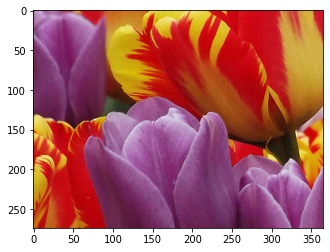

In [103]:
plt.imshow(img)

In [104]:
"""
copy_img = np.array(img)
mapping(copy_img, octree, palette_octree)
plt.imshow(copy_img)
"""

'\ncopy_img = np.array(img)\nmapping(copy_img, octree, palette_octree)\nplt.imshow(copy_img)\n'

In [105]:
# nb_leaf(octree)

In [106]:
"""
node = octree
depth = 1
c = [160, 136, 192]
while (not node.is_leaf):
    print(get_branch(c, depth))
    node = node.children[get_branch(c, depth)]
    depth += 1
"""

'\nnode = octree\ndepth = 1\nc = [160, 136, 192]\nwhile (not node.is_leaf):\n    print(get_branch(c, depth))\n    node = node.children[get_branch(c, depth)]\n    depth += 1\n'

In [107]:
# octree.children[7].children[1].children[4].children

## Dominante color extraction

In [108]:
def dominant_color_extraction(img, nb_colors, Mx=3, My=3):
    palette = []
    if Mx % 2 == 0 or My % 2 == 0:
        print("Invalid Mx or My values !")
        return
    difference_map = np.ones((img.shape[0], img.shape[1], 1)) * np.Inf
    grayscale = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    cielab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    nb_pixels_horizontal_scanlines = img.shape[1] * Mx
    nb_pixels_vertical_scanlines = Mx * My
    for _ in range(nb_colors):
        min_hori_Sr, index_hori_min = np.Inf, 0
        # Horizontal scanlines
        for index in range(img.shape[0] - (Mx - 1)):
            # Calculate S(R)
            denom = (
                np.sum(cielab[index:index + Mx, :, 0]) *
                np.sum(np.power(difference_map[index:index + Mx, :].flatten(), 2))
            )
            if (denom != 0):
                histo = np.bincount(grayscale[index:index + Mx, :].flatten())
                histo = histo[histo > 0] / nb_pixels_horizontal_scanlines
                Sr = ((-np.sum(histo * np.log2(histo))) * nb_pixels_horizontal_scanlines) / denom
                if (Sr <= min_hori_Sr):
                    min_hori_Sr, index_hori_min = Sr, index
        # Vertical scanlines
        min_vert_Sr, index_vert_min = np.Inf, 0
        histo_R = np.bincount(grayscale[index_hori_min:index_hori_min + Mx, :].flatten(), minlength=256) / nb_pixels_horizontal_scanlines
        for index in range(img.shape[1] - (My - 1)):
            # Calculate S(R)
            denom = (
                np.sum(cielab[index_hori_min:index_hori_min + Mx, index:index + My, 0]) *
                np.sum(np.power(difference_map[index_hori_min:index_hori_min + Mx, index:index + My].flatten(), 2))
            )
            if (denom != 0):
                histo = np.bincount(grayscale[index_hori_min:index_hori_min + Mx, index:index + My].flatten(), minlength=256)
                histo = histo_R[np.where(histo > 0)]
                Sr = (-(np.sum(histo * np.log2(histo))) * nb_pixels_vertical_scanlines) / denom
                if (Sr <= min_vert_Sr):
                    min_vert_Sr, index_vert_min = Sr, index
        selected_color = cielab[index_hori_min + Mx // 2, index_vert_min + My // 2]
        # append in palette
        palette.append(selected_color)
        # Update difference map
        for h in range(cielab.shape[0]):
            for w in range(cielab.shape[1]):
                if (difference_map[h, w][0] != 0):
                    diff = np.sqrt(
                        np.power(selected_color[0] - float(cielab[h, w][0]), 2) +
                        np.power(selected_color[1] - float(cielab[h, w][1]), 2) +
                        np.power(selected_color[2] - float(cielab[h, w][2]), 2)
                    )
                    if (diff < difference_map[h, w]):
                        difference_map[h, w][0] = diff
    return np.array(palette)

def apply_cielab_palette(cielab_img, palette):
    for h in range(cielab_img.shape[0]):
        for w in range(cielab_img.shape[1]):
            color = cielab_img[h, w]
            min_diff, saved = np.Inf, None
            for c in palette:
                diff = np.sqrt(
                    np.power(color[0] - float(c[0]), 2) +
                    np.power(color[1] - float(c[1]), 2) +
                    np.power(color[2] - float(c[2]), 2)
                )
                if (min_diff > diff):
                    min_diff = diff
                    saved = c
            cielab_img[h, w] = saved

In [109]:
palette_dominant_color = dominant_color_extraction(img, 16)

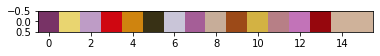

In [110]:
plt.imshow(cv.cvtColor(np.array([palette_dominant_color]), cv.COLOR_Lab2RGB))

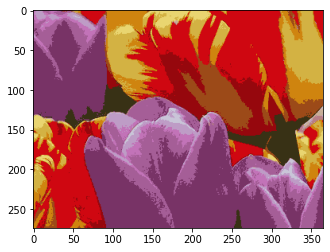

In [111]:
cielab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
apply_cielab_palette(cielab, palette_dominant_color)
# Recolorization
plt.imshow(cv.cvtColor(cielab, cv.COLOR_Lab2RGB))

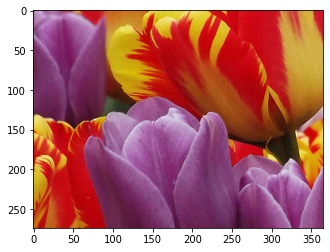

In [112]:
# Original image
plt.imshow(img)

# Experimental tests

In [113]:
imgs = ["butterfly.jpg", "Tiger.jpg", "eagle.jpg", "painting.jpg", "Sunflower.jpg"]

In [114]:
def mse(img1, img2):
    return np.mean(np.power(img1 - img2, 2).flatten())

def delta_Ecielab76(img1, img2):
    img1 = cv.cvtColor(img1, cv.COLOR_RGB2Lab)
    img2 = cv.cvtColor(img2, cv.COLOR_RGB2Lab)
    return np.mean(np.power(img1 - img2, 2).flatten())

def calculate_colorfulness(img):
    rg = img[:, :, 0] - img[:, :, 1]
    yb = 0.5 * (img[:, :, 0] + img[:, :, 1]) - img[:, :, 2]
    return np.sqrt(np.std(rg)**2 + np.std(yb)**2) + 0.3 * np.sqrt(np.mean(rg)**2 + np.mean(yb)**2)

## Results with MSE

In [115]:
"""
for img_name in imgs:
    img = cv.imread(PICTURE_PATH + img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    print(img_name)
    print("Median cut")
    copy_img = np.array(img)
    median_cut(copy_img, 5) 
    print(mse(img, copy_img))
    print("Octree")
    octree = GenerateOctree(img, 32)
    palette_octree = initPalette(octree)
    copy_img = np.array(img)
    mapping(copy_img, octree, palette_octree)
    print(mse(img, copy_img))
    # print("Region extraction")
    # palette_dominant_color = dominant_color_extraction(img, 16)
    # cielab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    # apply_cielab_palette(cielab, palette_dominant_color)
    # print(mse(img, cv.cvtColor(cielab, cv.COLOR_Lab2RGB)))
""" 

'\nfor img_name in imgs:\n    img = cv.imread(PICTURE_PATH + img_name)\n    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)\n    print(img_name)\n    print("Median cut")\n    copy_img = np.array(img)\n    median_cut(copy_img, 5) \n    print(mse(img, copy_img))\n    print("Octree")\n    octree = GenerateOctree(img, 32)\n    palette_octree = initPalette(octree)\n    copy_img = np.array(img)\n    mapping(copy_img, octree, palette_octree)\n    print(mse(img, copy_img))\n    # print("Region extraction")\n    # palette_dominant_color = dominant_color_extraction(img, 16)\n    # cielab = cv.cvtColor(img, cv.COLOR_RGB2Lab)\n    # apply_cielab_palette(cielab, palette_dominant_color)\n    # print(mse(img, cv.cvtColor(cielab, cv.COLOR_Lab2RGB)))\n'

## Results with Delta-E

In [116]:
"""
for img_name in imgs:
    img = cv.imread(PICTURE_PATH + img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    print(img_name)
    print("Median cut")
    copy_img = np.array(img)
    median_cut(copy_img, 5) 
    print(delta_Ecielab76(img, copy_img))
    print("Octree")
    octree = GenerateOctree(img, 32)
    palette_octree = initPalette(octree)
    copy_img = np.array(img)
    mapping(copy_img, octree, palette_octree)
    print(delta_Ecielab76(img, copy_img))
"""

'\nfor img_name in imgs:\n    img = cv.imread(PICTURE_PATH + img_name)\n    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)\n    print(img_name)\n    print("Median cut")\n    copy_img = np.array(img)\n    median_cut(copy_img, 5) \n    print(delta_Ecielab76(img, copy_img))\n    print("Octree")\n    octree = GenerateOctree(img, 32)\n    palette_octree = initPalette(octree)\n    copy_img = np.array(img)\n    mapping(copy_img, octree, palette_octree)\n    print(delta_Ecielab76(img, copy_img))\n'

## Results with colorfulness

In [117]:
"""
for img_name in imgs:
    img = cv.imread(PICTURE_PATH + img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    print(img_name)
    print("Median cut")
    copy_img = np.array(img)
    median_cut(copy_img, 5)
    print(np.abs(calculate_colorfulness(img) - calculate_colorfulness(copy_img)))
    print("Octree")
    octree = GenerateOctree(img, 32)
    palette_octree = initPalette(octree)
    copy_img = np.array(img)
    mapping(copy_img, octree, palette_octree)
    print(np.abs(calculate_colorfulness(img) - calculate_colorfulness(copy_img)))
"""

'\nfor img_name in imgs:\n    img = cv.imread(PICTURE_PATH + img_name)\n    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)\n    print(img_name)\n    print("Median cut")\n    copy_img = np.array(img)\n    median_cut(copy_img, 5)\n    print(np.abs(calculate_colorfulness(img) - calculate_colorfulness(copy_img)))\n    print("Octree")\n    octree = GenerateOctree(img, 32)\n    palette_octree = initPalette(octree)\n    copy_img = np.array(img)\n    mapping(copy_img, octree, palette_octree)\n    print(np.abs(calculate_colorfulness(img) - calculate_colorfulness(copy_img)))\n'